In [1]:
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import pandas as pd
import numpy as np
sys.path.append(r'C:\Users\Joar\Documents\1_Education\NTNU\OneDrive - NTNU\Thesis\Modelling\FD Model')
import time
import pickle
from scipy.optimize import minimize

In [2]:
#from OptimizationProblem_headangle import OptimizationProblem
from Design_Exploration import OptimizationProblem
from WindForceSpectrum import WindForceSpectrum
from scipy import interpolate
from plot_hydroD_results import plot_hydroD_results
from FloaterParameters import FloaterParameters
from Environment import Environment
from Buoy import Buoy
from Mass import Mass
from Density import Density
from Area import Area
from GlobalCoordinateSystem import GlobalCoordinateSystem
from SystemMatrices import MatrixCalculation
from WindForceSpectrum import WindForceSpectrum
from WaveSpectrumAnalysis import wavespectrumanalysis
from scipy import interpolate
from InterpolateHydroDResults import InterpolateResults
from RAO_Calculation import calulate_RAOs
from jonswap import jonswap
from WindSpectrumAnalysis import windspectrumanalysis
from SpectrumStatistics import spectrum_response_statistics
from HydroDInterpolation import LinearInterpolate, Interpolate2d, Interpolate4d

In [3]:
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'serif' 

In [4]:
dia= np.arange(11.,13.,.1)

In [5]:
sa = np.zeros(shape=(len(dia),2,3,8))
tz = np.zeros(shape=(len(dia),2,3,8))
mpm = np.zeros(shape=(len(dia),2,3,8))
rao_wave = np.zeros(shape=(len(dia),2, 3, 28592, 8)) +0j
rao_wind = np.zeros(shape=(len(dia),2, 3, 180000, 8)) +0j
stiffness = np.zeros(shape=(len(dia),6,6))
nat_freq_damped = np.zeros(shape=(len(dia),6))
steel_mass = np.zeros(shape=(len(dia),2,3,8))
wind_response= np.zeros(shape=(len(dia),3, 180000, 8))

In [6]:
for jj, y in enumerate(dia):
    print(y)
    sa[jj,:,:,:], mpm[jj,:,:,:], rao_wave[jj,:,:,:,:], rao_wind[jj,:,:,:,:], stiffness[jj,:,:], nat_freq_damped[jj,:], _, wind_response[jj,:,:,:], tz[jj,:,:,:] = OptimizationProblem(59, 50, y, 8)

11.0


C:\Users\Joar\Documents\1_Education\NTNU\OneDrive - NTNU\Thesis\Modelling\FD Model\SpectrumStatistics.py:51: RuntimeWarning: invalid value encountered in true_divide
  Tz[jj, DOF[ii]] = 2 * np.pi * np.sqrt(np.divide(m0[jj, DOF[ii]], m2[jj, DOF[ii]]))


11.1
11.2
11.299999999999999
11.399999999999999
11.499999999999998
11.599999999999998
11.699999999999998
11.799999999999997
11.899999999999997
11.999999999999996
12.099999999999996
12.199999999999996
12.299999999999995
12.399999999999995
12.499999999999995
12.599999999999994
12.699999999999994
12.799999999999994
12.899999999999993


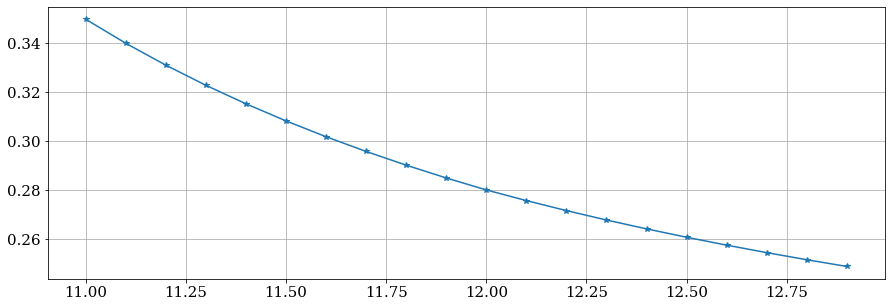

In [16]:
plt.plot(dia, mpm[:,1,0,3], '-*')
#plt.ylim(0,30)

# 1. Check Wave Influence

In [8]:
def wave_component(x_space, y_space, dia_column, draft):
    env = Environment()
    rho = Density()
    mufp = FloaterParameters(x_space, y_space, dia_column, draft)
    csa = Area(mufp)
    buoy = Buoy(mufp, csa, rho)
    mass = Mass(mufp, csa, buoy, rho)
    coord = GlobalCoordinateSystem(mufp, csa, mass, rho, buoy, env)
    matrix = MatrixCalculation(coord, mass, mufp, rho, env, csa, buoy)
    # Adding artificial stiffness in DOF without any
    matrix.stiffness[0, 0] = 1e6
    matrix.stiffness[1, 1] = 1e6
    matrix.stiffness[5, 5] = 1e9
    
    Tr = 3 * 3600  # 3 hour return period


    # Finding the nearest HydroD simulations for surrogate model
    interp_inputs = np.array([[np.floor(x_space / 10) * 10, np.floor(y_space / 10) * 10, np.floor(dia_column), np.floor(draft / 2) * 2],
                              [np.floor(x_space / 10) * 10, np.floor(y_space / 10) * 10, np.ceil(dia_column), np.floor(draft / 2) * 2]])#,
                              #[np.ceil(x_space / 10) * 10, np.ceil(y_space / 10) * 10, np.floor(dia_column), np.floor(draft / 2) * 2],
                              #[np.floor(x_space / 10) * 10, np.ceil(y_space / 10) * 10, np.floor(dia_column), np.floor(draft / 2) * 2],
                              #[np.ceil(x_space / 10) * 10, np.floor(y_space / 10) * 10, np.ceil(dia_column), np.ceil(draft / 2) * 2],
                              #[np.floor(x_space / 10) * 10, np.floor(y_space / 10) * 10, np.ceil(dia_column), np.ceil(draft / 2) * 2],
                              #[np.ceil(x_space / 10) * 10, np.ceil(y_space / 10) * 10, np.ceil(dia_column), np.ceil(draft / 2) * 2],
                              #[np.floor(x_space / 10) * 10, np.ceil(y_space / 10) * 10, np.ceil(dia_column), np.ceil(draft / 2) * 2]])

    # Interpolating surrogate models to get estimate
    design = [x_space, y_space, dia_column, draft]
    results = []

    for i in np.linspace(0, len(interp_inputs[:, 1]) - 1, len(interp_inputs)).astype(int):
        file_loc = r'E:\pickle_files'
        file_name = "\sim_x_%d_y_%d_D%d_dr%d" % (
        interp_inputs[i, 0], interp_inputs[i, 1], interp_inputs[i, 2], interp_inputs[i, 3])
        file_path = file_loc + file_name
        infile = open(file_path, 'rb')
        results.append(pickle.load(infile))
        infile.close()

    sim = LinearInterpolate(results, interp_inputs, design, 2)

    # Adding 5% critical damping
    if matrix.stiffness[4, 4] > 0 and matrix.stiffness[3, 3] > 0:
        sim.DAMPING += (1/20)*2*np.sqrt(matrix.stiffness * (matrix.mass+sim.ADDEDMASS))
    else:
        print('Negative Stiffness - No Critical Damping')

    nat_freq_undamped = np.sqrt(np.diag(matrix.stiffness) / np.diag(matrix.mass + sim.ADDEDMASS[0,:,:]))
    nat_freq_damped = nat_freq_undamped*np.sqrt(1-0.05)

    # Defining frequencies of interest
    f_rad = np.array([1e-7])
    df = 1 / 36000
    df_rad = (2 * np.pi) * df
    f_rad = np.concatenate([f_rad, np.arange(0.01, 5, df_rad)])

    # Spectral Moment Analysis
    Tz, Significant_Amplitude, N_mpm, MPM, RAO, Y, H, Y_inv = wavespectrumanalysis(sim, matrix, 0, mufp, coord, df_rad,
                                                                              f_rad, Tr)
    return Tz, Significant_Amplitude, N_mpm, MPM, RAO, Y, H, Y_inv

In [9]:
Tz_wave = np.zeros(shape=(len(dia),2,3,8))
Significant_Amplitude_wave = np.zeros(shape=(len(dia),2,3,8))
N_mpm_wave = np.zeros(shape=(len(dia),2,3,8))
MPM_wave = np.zeros(shape=(len(dia),2,3,8))
rao_wave = np.zeros(shape=(len(dia),2, 3, 28592, 8)) +0j

In [10]:
for jj, y in enumerate(dia):
    Tz_wave[jj,:,:,:], Significant_Amplitude_wave[jj,:,:,:], N_mpm_wave[jj,:,:,:], MPM_wave[jj,:,:,:], rao_wave[jj,:,:,:,:], _, _, _ =  wave_component(59, 50, y, 8)

C:\Users\Joar\Documents\1_Education\NTNU\OneDrive - NTNU\Thesis\Modelling\FD Model\SpectrumStatistics.py:51: RuntimeWarning: invalid value encountered in true_divide
  Tz[jj, DOF[ii]] = 2 * np.pi * np.sqrt(np.divide(m0[jj, DOF[ii]], m2[jj, DOF[ii]]))


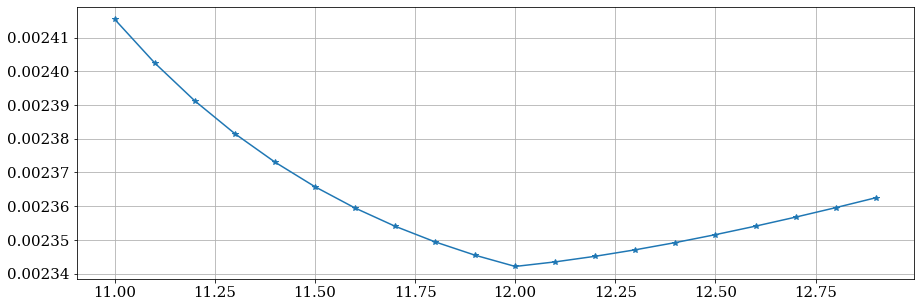

In [11]:
plt.plot(dia, MPM_wave[:,1,0,3], '-*')
#plt.ylim(0,30)

In [12]:
    # Defining frequencies of interest
    f_rad = np.array([1e-7])
    df = 1 / 3600
    df_rad = (2 * np.pi) * df
    f_rad = np.concatenate([f_rad, np.arange(0.01, 5, df_rad)])

In [13]:
np.abs(rao_wave[0,1,0,:,3])

array([6.03576239e-04, 6.08795562e-04, 6.19718411e-04, ...,
       5.81743378e-08, 5.82322856e-08, 5.82902348e-08])

ValueError: x and y must have same first dimension, but have shapes (2861,) and (28592,)

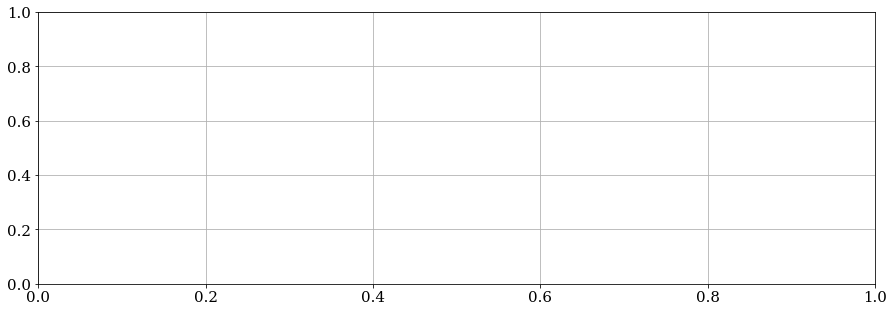

In [14]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
for ii, jj in enumerate(np.arange(0,38,2)):
    plt.plot(f_rad, np.abs(rao_wave[ii,1,0,:,3]), '-*', markersize=4, linewidth=3, label='Diameter = %f' % dia[ii])
plt.ylabel('Pitch Wind Response [rad/N]')
plt.xlabel('Frequency [rad/s]')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.xlim(0.03,0.06)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.01))

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
for ii, jj in enumerate(np.arange(0,38,2)):
    plt.plot(f_rad, np.abs(rao_wave[ii,0,0,:,4]), '-*', markersize=4, linewidth=3, label='Diameter = %f' % dia[ii])
plt.ylabel('Pitch Wind Response [rad/N]')
plt.xlabel('Frequency [rad/s]')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.xlim(0,2)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.01))

# Now check the wind loading contribution

In [ ]:
plt.plot(dia, stiffness[:,3,3], '-*')
#plt.ylim(0,30)

In [ ]:
def wind_component(x_space, y_space, dia_column, draft):
    
    env = Environment()
    rho = Density()
    mufp = FloaterParameters(x_space, y_space, dia_column, draft)
    csa = Area(mufp)
    buoy = Buoy(mufp, csa, rho)
    mass = Mass(mufp, csa, buoy, rho)
    coord = GlobalCoordinateSystem(mufp, csa, mass, rho, buoy, env)
    matrix = MatrixCalculation(coord, mass, mufp, rho, env, csa, buoy)
    # Adding artificial stiffness in DOF without any
    matrix.stiffness[0, 0] = 1e6
    matrix.stiffness[1, 1] = 1e6
    matrix.stiffness[5, 5] = 1e9
    
        
    Tr = 3 * 3600  # 3 hour return period


    # Finding the nearest HydroD simulations for surrogate model
    interp_inputs = np.array([[np.floor(x_space / 10) * 10, np.floor(y_space / 10) * 10, np.floor(dia_column), np.floor(draft / 2) * 2],
                              [np.floor(x_space / 10) * 10, np.floor(y_space / 10) * 10, np.ceil(dia_column), np.floor(draft / 2) * 2]])#,
                              #[np.ceil(x_space / 10) * 10, np.ceil(y_space / 10) * 10, np.floor(dia_column), np.floor(draft / 2) * 2],
                              #[np.floor(x_space / 10) * 10, np.ceil(y_space / 10) * 10, np.floor(dia_column), np.floor(draft / 2) * 2],
                              #[np.ceil(x_space / 10) * 10, np.floor(y_space / 10) * 10, np.ceil(dia_column), np.ceil(draft / 2) * 2],
                              #[np.floor(x_space / 10) * 10, np.floor(y_space / 10) * 10, np.ceil(dia_column), np.ceil(draft / 2) * 2],
                              #[np.ceil(x_space / 10) * 10, np.ceil(y_space / 10) * 10, np.ceil(dia_column), np.ceil(draft / 2) * 2],
                              #[np.floor(x_space / 10) * 10, np.ceil(y_space / 10) * 10, np.ceil(dia_column), np.ceil(draft / 2) * 2]])

    # Interpolating surrogate models to get estimate
    design = [x_space, y_space, dia_column, draft]
    results = []

    for i in np.linspace(0, len(interp_inputs[:, 1]) - 1, len(interp_inputs)).astype(int):
        file_loc = r'E:\pickle_files'
        file_name = "\sim_x_%d_y_%d_D%d_dr%d" % (
        interp_inputs[i, 0], interp_inputs[i, 1], interp_inputs[i, 2], interp_inputs[i, 3])
        file_path = file_loc + file_name
        infile = open(file_path, 'rb')
        results.append(pickle.load(infile))
        infile.close()

    sim = LinearInterpolate(results, interp_inputs, design, 2)

     # Wind Loading Spectrum Analysis
    # Pulling Wind Force Spectrum from SIMA simulation
    f_xx, sx_wind, sy_wind, smz_wind = WindForceSpectrum()
    df = 1 / 36000
    df_rad = (2 * np.pi) * df
    f = np.arange(0, f_xx[-1], df_rad)  # Defining new frequency range
    func_f = interpolate.interp1d(f_xx, sx_wind)
    sx_wind = func_f(f)

    func_f = interpolate.interp1d(f_xx, sy_wind)
    sy_wind = func_f(f)

    func_f = interpolate.interp1d(f_xx, smz_wind)
    smz_wind = func_f(f)

    # Applying full force to surge and pitch & misalignment force to sway and roll
    s_wind = np.zeros(shape=(len(f), 8))
    s_wind[:, 0] = sx_wind
    s_wind[:, 1] = sy_wind
    s_wind[:, 3] = sy_wind
    s_wind[:, 4] = sx_wind
    s_wind[:, 5] = smz_wind

    tz_wind, sa_wind, n_mpm_wind, mpm_wind, wind_response, rao_wind, Y, H = windspectrumanalysis(sim, matrix,
                                                                                                           0, mufp,
                                                                                                           coord,
                                                                                                           df_rad, f,
                                                                                                           Tr, s_wind)
    return tz_wind, sa_wind, n_mpm_wind, mpm_wind, wind_response, rao_wind, Y, H

In [ ]:
sa_wind = np.zeros(shape=(len(dia),2,3,8))
n_mpm_wind = np.zeros(shape=(len(dia),2,3,8))
tz_wind = np.zeros(shape=(len(dia),2,3,8))
mpm_wind = np.zeros(shape=(len(dia),2,3,8))
rao_wind = np.zeros(shape=(len(dia),2, 3, 18000, 8)) + 0j
wind_response= np.zeros(shape=(len(dia), 3, 18000, 8)) + 0j

In [ ]:
for jj, y in enumerate(dia):
    tz_wind[jj,:,:,:], sa_wind[jj,:,:,:], n_mpm_wind[jj,:,:,:], mpm_wind[jj,:,:,:], wind_response[jj,:,:,:], rao_wind[jj,:,:,:,:], _, _ =  wind_component(59, 50, y, 8)

In [ ]:
f_xx, sx_wind, sy_wind, smz_wind = WindForceSpectrum()
df_rad = 1/3600
f = np.arange(0, f_xx[-1], df_rad)  # Defining new frequency range

In [ ]:
plt.plot(dia,mpm_wind[:,1,0,3])

In [ ]:
plt.plot(dia,mpm_wind[:,0,0,4])

In [ ]:
tz_wind, sa_wind, n_mpm_wind, mpm_wind, wind_response, rao_wind, _, _ =  wind_component(59, 50, 11.5, 8)

In [ ]:
wind_response.shape

In [ ]:
rao_wind.shape

# Seeing as this happens in both excitation forces, the problem might lie in the RAO

In [ ]:
def RAO_section(x_space, y_space, dia_column, draft):
    plot = 0
    env = Environment()
    rho = Density()
    mufp = FloaterParameters(x_space, y_space, dia_column, draft)
    csa = Area(mufp)
    buoy = Buoy(mufp, csa, rho)
    mass = Mass(mufp, csa, buoy, rho)
    coord = GlobalCoordinateSystem(mufp, csa, mass, rho, buoy, env)
    matrix = MatrixCalculation(coord, mass, mufp, rho, env, csa, buoy)
    # Adding artificial stiffness in DOF without any
    matrix.stiffness[0, 0] = 1e6
    matrix.stiffness[1, 1] = 1e6
    matrix.stiffness[5, 5] = 1e9

    # Defining return period for statistical evaluation
    Tr = 3 * 3600  # 3 hour return period


    # Finding the nearest HydroD simulations for surrogate model
    interp_inputs = np.array([[np.floor(x_space / 10) * 10, np.floor(y_space / 10) * 10, np.floor(dia_column), np.floor(draft / 2) * 2],
                              [np.floor(x_space / 10) * 10, np.floor(y_space / 10) * 10, np.ceil(dia_column), np.floor(draft / 2) * 2]])#,
                              #[np.ceil(x_space / 10) * 10, np.ceil(y_space / 10) * 10, np.floor(dia_column), np.floor(draft / 2) * 2],
                              #[np.floor(x_space / 10) * 10, np.ceil(y_space / 10) * 10, np.floor(dia_column), np.floor(draft / 2) * 2],
                              #[np.ceil(x_space / 10) * 10, np.floor(y_space / 10) * 10, np.ceil(dia_column), np.ceil(draft / 2) * 2],
                              #[np.floor(x_space / 10) * 10, np.floor(y_space / 10) * 10, np.ceil(dia_column), np.ceil(draft / 2) * 2],
                              #[np.ceil(x_space / 10) * 10, np.ceil(y_space / 10) * 10, np.ceil(dia_column), np.ceil(draft / 2) * 2],
                              #[np.floor(x_space / 10) * 10, np.ceil(y_space / 10) * 10, np.ceil(dia_column), np.ceil(draft / 2) * 2]])

    # Interpolating surrogate models to get estimate
    design = [x_space, y_space, dia_column, draft]
    results = []

    for i in np.linspace(0, len(interp_inputs[:, 1]) - 1, len(interp_inputs)).astype(int):
        file_loc = r'E:\pickle_files'
        file_name = "\sim_x_%d_y_%d_D%d_dr%d" % (
        interp_inputs[i, 0], interp_inputs[i, 1], interp_inputs[i, 2], interp_inputs[i, 3])
        file_path = file_loc + file_name
        infile = open(file_path, 'rb')
        results.append(pickle.load(infile))
        infile.close()


    sim = LinearInterpolate(results, interp_inputs, design, 2)
    #sim = Interpolate3d(results, interp_inputs, design)

    # Adding 5% critical damping
    if matrix.stiffness[4, 4] > 0 and matrix.stiffness[3, 3] > 0:
        sim.DAMPING += (1/20)*2*np.sqrt(matrix.stiffness * (matrix.mass+sim.ADDEDMASS))
    else:
        print('Negative Stiffness - No Critical Damping')

    nat_freq_undamped = np.sqrt(np.diag(matrix.stiffness) / np.diag(matrix.mass + sim.ADDEDMASS[0,:,:]))
    nat_freq_damped = nat_freq_undamped*np.sqrt(1-0.05)

    # Defining frequencies of interest
    f_rad = np.array([1e-7])
    df = 1 / 36000
    df_rad = (2 * np.pi) * df
    f_rad = np.concatenate([f_rad, np.arange(0.01, 5, df_rad)])
    
    sim_interp = InterpolateResults(sim, f_rad)
    
    unit_force = np.ones(shape=(2, len(f_rad), 6, 4)) + 0j
    unit_force[:, :, 3:5, 0] = mufp.hub_height + 0j
    unit_force[:, :, 3:5, 1] = mufp.hub_height + 0j


    X, Y, H, Y_inv =  calulate_RAOs(sim_interp.wave_disc, matrix.mass, sim_interp.ADDEDMASS, sim_interp.DAMPING,
                                       matrix.stiffness,
                                       unit_force, plot, mufp, coord)
    return X, Y, H, Y_inv, sim.wave_disc
    

In [ ]:
f_rad = np.array([1e-7])
df = 1 / 36000
df_rad = (2 * np.pi) * df
f_rad = np.concatenate([f_rad, np.arange(0.01, 5, df_rad)])

In [ ]:
X = np.zeros(shape=(len(dia),2, 3, len(f_rad), 8)) + 0j
Y = np.zeros(shape=(len(dia),len(f_rad), 6, 6))+ 0j
H = np.zeros(shape=(len(dia),2, len(f_rad), 6))+ 0j
Y_inv = np.zeros(shape=(len(dia),len(f_rad), 6, 6))+ 0j

In [ ]:
for jj, y in enumerate(dia):
    X[jj,:,:,:,:], Y[jj,:,:,:], H[jj,:,:,:], Y_inv[jj,:,:,:], wave_disc =  RAO_section(59, 50, y, 8)

In [ ]:
f_rad = np.array([1e-7])
df = 1 / 3600
df_rad = (2 * np.pi) * df
f_rad = np.concatenate([f_rad, np.arange(0.01, 5, df_rad)])

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
for ii, jj in enumerate(np.arange(0,38,4)):
    plt.plot(f_rad, np.abs(X[ii,0,0,:,4]), '-*', markersize=4, linewidth=3, label='Diameter = %.2f' % dia[ii])
plt.ylabel('Pitch Wind Response [rad/N]')
plt.xlabel('Frequency [rad/s]')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.xlim(0,.75)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.01))

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
for ii, jj in enumerate(np.arange(0,38,2)):
    plt.plot(f_rad, np.abs(X[ii,1,0,:,3]), '-*', markersize=10, linewidth=3, label='Diameter = %f' % dia[ii])
plt.ylabel('Pitch Wind Response [rad/N]')
plt.xlabel('Frequency [rad/s]')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.xlim(0,0.06)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.01))

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
for ii, jj in enumerate(np.arange(0,38,2)):
    plt.plot(f_rad, np.real(Y[ii,:,3,3]), '-*', markersize=10, linewidth=3, label='Diameter = %f' % dia[ii])
plt.ylabel('Pitch Wind Response [rad/N]')
plt.xlabel('Frequency [rad/s]')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.xlim(0,.5)
plt.ylim(0,1e8)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.01))

In [ ]:
1/3600

In [ ]:
Y_inv.shape